# Workflow Final

### Sommaire

* [1. Import de librairies](#imports)
* [2. Variables globales](#variables)
* [3. Import du classifieur (CNN)](#classifieur)
* [4. Import du débruiteur](#denoiser)
* [5. Import du modèle de captioning (CNN + RNN)](#captioning)
* [6. Construction du pipeline](#pipeline)
* [7. Chargement de données](#donnees)
* [8. Inférence (Prédictions)](#inference)
* [9. Affichage de quelque prédictions](#ploting)

### 1. Import de librairies <a class="anchor" id="imports"></a>

In [338]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 2. Variables globales <a class="anchor" id="variables"></a>

In [339]:
IMG_SIZE = 64               
BATCH_SIZE = 8     
DATASET_PATH = './dataset_livrable_1'   

### 3. Import du classifieur (CNN) <a class="anchor" id="classifieur"></a>

In [340]:
classifier = tf.keras.models.load_model('classifier.keras')
# classifier.summary()

### 4. Import du débruiteur <a class="anchor" id="denoiser"></a>

In [341]:
denoiser = tf.keras.models.load_model('denoiser.keras')
# denoiser.summary()

### 5. Import du modèle de captioning (CNN + RNN) <a class="anchor" id="captioning"></a>

In [342]:
# captioner = tf.keras.models.load_model('captioner.keras')

### 6. Construction du pipeline <a class="anchor" id="pipeline"></a>

In [343]:
class Pipeline():
    def __init__(self, classifier, denoiser=None, captioner=None, img_size=64, denoiser_img_size=224):
        self.classifier = classifier
        self.denoiser = denoiser
        self.captioner = captioner
        self.img_size = img_size
        self.denoiser_img_size = denoiser_img_size

    def binary_label(self, images, labels, dataset):
        """Fonction pour convertir les étiquettes en format binaire."""
        target_label = dataset.class_names.index('Photo')
        binary_labels = tf.where(labels == target_label, 1, 0)
        return images, binary_labels

    def select_photos(self, predictions, dataset, batch_size=16):
        batch = []
        for pred, (image, label) in zip(predictions, dataset.unbatch()):
            if pred == 1:  # If the predicted class for this image is 1
                batch.append(image)
                if len(batch) == batch_size:
                    yield np.stack(batch), np.stack(batch)
                    batch = []
        if batch:  # If there are any images left in the batch
            yield np.stack(batch), np.stack(batch)

    def __call__(self, dataset):
        # 1. Transform labels to binary
        dataset = dataset.map(lambda x, y: self.binary_label(x, y, dataset))

        # 2. Normalize image data
        normalization_layer = tf.keras.layers.Rescaling(1./255)
        dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

        # 3. Use the classifier model
        classifier_predictions = self.classifier.predict(dataset)

        # 4. Select only the photos given the previous classification data
        classifier_predictions_labels = (classifier_predictions > 0.5).astype(int)
        selected_photos = self.select_photos(classifier_predictions_labels, dataset)

        # Create a Dataset from the "selected_photos" generator
        photo_dataset = tf.data.Dataset.from_generator(
            lambda: selected_photos,
            output_signature=(
                tf.TensorSpec(shape=(None, self.img_size, self.img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, self.img_size, self.img_size, 3), dtype=tf.float32)
            )
        )
        # 5. Resize the selected photos to (None, 224, 224, 3)
        resized_photos = photo_dataset.map(lambda x, y: (tf.image.resize(x, [self.denoiser_img_size, self.denoiser_img_size]), y))
        
        # 6. Apply denoising to the photos
        denoised_images = self.denoiser.predict(resized_photos)

        # Generate a caption for the denoised image using the captioner model
        # caption = captioner.predict(denoised_image)

        # return classification, caption
        return denoised_images

### 7. Chargement de données <a class="anchor" id="donnees"></a>

In [344]:
# Load the dataset
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,   
    validation_split=0.2,   
    subset="training", 
    seed=123,  
    shuffle=True,  
    image_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE,     
    label_mode='int'  
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'  
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


### 8. Inférence (Prédictions) <a class="anchor" id="inference"></a>

In [345]:
pipeline = Pipeline(classifier=classifier, denoiser=denoiser, img_size=IMG_SIZE, denoiser_img_size=IMG_SIZE)

In [346]:
photos = pipeline(train_set)
print(photos.shape)

2273/4140 ━━━━━━━━━━━━━━━━━━━━ 2:40 86ms/step

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


4140/4140 ━━━━━━━━━━━━━━━━━━━━ 329s 77ms/step
    298/Unknown 157s 521ms/step

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


553/553 ━━━━━━━━━━━━━━━━━━━━ 289s 519ms/step


2024-04-24 16:29:10.682522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


(8840, 64, 64, 3)


### 9. Affichage de quelque prédictions <a class="anchor" id="ploting"></a>

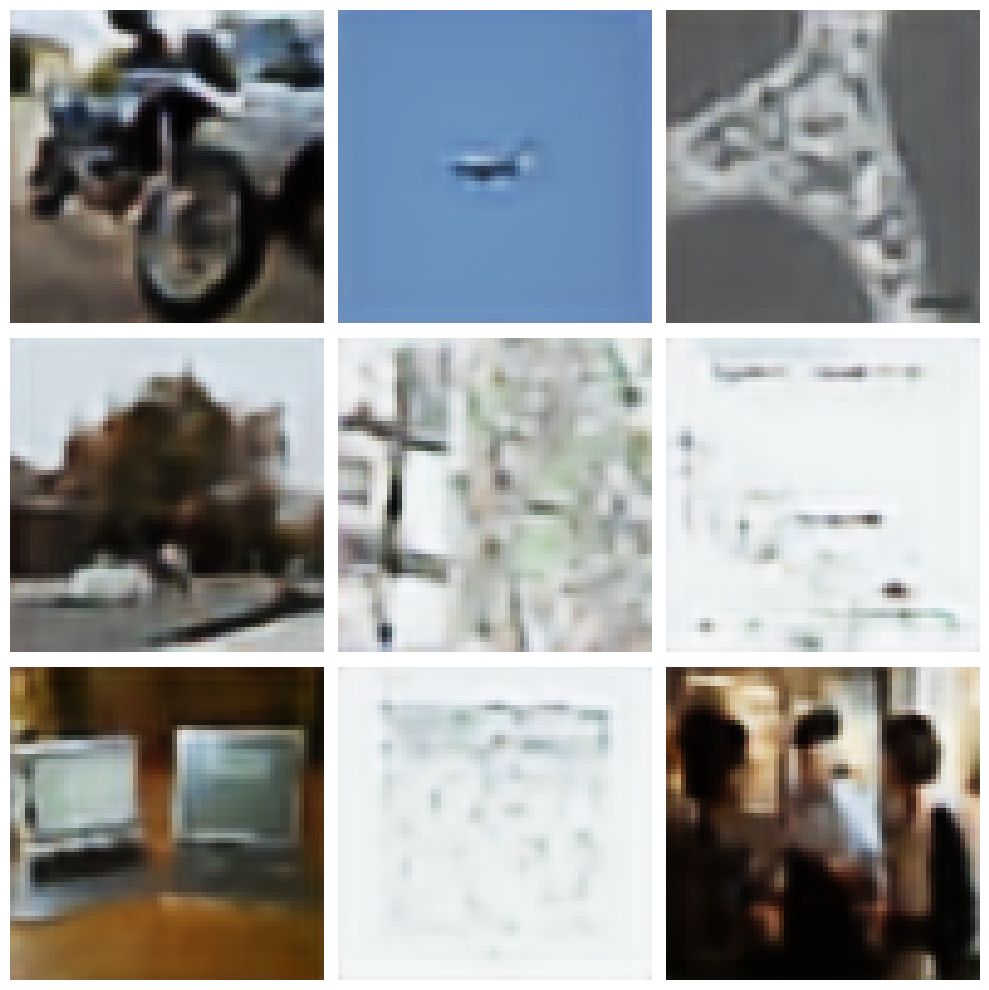

In [347]:
def display_images(images, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(photos)